# Particle Telescope Notebook

In this notebook, we investigate how the **SIXS-P** particle instrument onboard **BepiColombo** detects **electrons** and **protons** by analyzing the energy deposition in its detector layers using **Geant4** simulations.


<img src="11214_2020_717_Fig8_HTML.png" width="500">

**Figure 1. A schematic picture of a cross section of SIXS-P.**

---

## Detector stack under study
- **Beryllium** and **Kapton** foils (used for particle discrimination and thermal control),
- A **Side** detector: 150 μm thick **Si**,
- A **Core** detector: 5 × 5 × 6.3 mm3 **CsI(Tl) scintillator**.

<img src="Side_0-stack.png" width="500">

**Figure 2. 3D model showing the foils and detector layers on Side 0, along with the Core detector of the SIXS-P instrument.**

---

## Dataset
Simulations were performed beforehand for electrons and protons separately, using a flat energy spectrum and a particle beam incident normal to Side 0 of the instrument. The simulation data, which records the incident particle energy and the energy deposited in the detector layers relevant to this study, has been saved in CSV format.

We begin the analysis using a nominal energy range of:
> -      Electrons: 40 keV – 3 MeV
> -      Protons: 0.7 – 30 MeV

If time permits, we will extend the analysis to explore the instrument's response to higher energies:
> -       Electrons: 100 keV – 10 MeV
> -       Protons: 3 – 1 GeV



## Analysis Overview
This study is structured into three main parts:
1.      Coincidence analysis – Events where both the Side and Core detectors register a hit.
2.      Anti-coincidence analysis – Events with a hit in the Side detector but no hit in the Core detector.
3.      Instrument response – Analyzing the energy-dependent detection.
---

## Reading and displaying dataset

In [1]:
#  Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# User-defined setting to select energy range
high_energies = False  # Set to True to use high-energy data files

# ------------------------------------------------------------------
# Reading input files based on the selected energy range

lowe_filenames = ["out_e.csv", "out_p.csv"]          # Low-energy electron and proton data
highe_filenames = ["out_e_high.csv", "out_p_high.csv"]  # High-energy electron and proton data

# Select appropriate filenames
filenames = highe_filenames if high_energies else lowe_filenames

# Read the data into DataFrames
dfs = [pd.read_csv(fname) for fname in filenames]


### <img src="electron_beam.png" width="1000">

**Figure 3. Geant4 simulation of the SIXS-P model exposed to an electron beam incident normally on Side 0. Blue rays represent primary electrons from the source and scattered electrons, while green rays indicate secondary photons produced by the interactions.**

In [3]:
# Display the electron dataset (first file in the list)
display(dfs[0])

,Egun_MeV,Edep_Beryllium_foil0_MeV,Edep_Kapton_foil0_MeV,Edep_Si_side0_MeV,Edep_Scintillator_MeV
0,0.040040,0.005808,0.009662,0.024265,0.000000
1,0.040050,0.006038,0.010829,0.000000,0.000000
2,0.040052,0.006089,0.033963,0.000000,0.000000
3,0.040054,0.016101,0.011544,0.000000,0.000000
4,0.040074,0.004355,0.010941,0.000000,0.000000
...,...,...,...,...,...
13213,2.999178,0.005418,0.000000,0.000000,0.000000
13214,2.999288,0.001264,0.000000,0.000000,0.000000
13215,2.999505,0.000856,0.001283,0.000000,2.146595
13216,2.999673,0.000683,0.000632,0.000000,0.000000


#### <img src="proton_beam.png" width="1000">

**Figure 4. Geant4 simulation of the SIXS-P model exposed to a proton beam incident normally on Side 0. Red rays represent primary protons from the source, while green rays indicate secondary photons produced by the interactions.**

In [4]:
# Display proton dataset (second file in the list)
display(dfs[1])

,Egun_MeV,Edep_Beryllium_foil0_MeV,Edep_Kapton_foil0_MeV,Edep_Si_side0_MeV,Edep_Scintillator_MeV
0,0.701154,0.323184,0.377943,0.0,0.000000
1,0.704357,0.363220,0.341137,0.0,0.000000
2,0.705527,0.321020,0.384488,0.0,0.000000
3,0.717654,0.280737,0.425920,0.0,0.000000
4,0.718063,0.325518,0.392545,0.0,0.000000
...,...,...,...,...,...
14954,29.994188,0.014841,0.032380,0.0,0.000000
14955,29.995620,0.009919,0.024550,0.0,0.000000
14956,29.996091,0.014487,0.020302,0.0,22.474419
14957,29.998081,0.009392,0.017326,0.0,0.000000


## 1. Coincidence analysis
This section analyzes events where both the Side and Core detectors register a hit.

In [5]:
#
# Selection of coincidence hits, i.e., events registered by both the Side and Core detectors.
# Criteria: particles depositing at least 0.035 MeV in the Side detector
# and a minimum of 0.5 MeV in the Core detector.
#

# Set detection threshold 
CORE_THRESHOLD = 0.5 # MeV
SIDE_THRESHOLD = 0.035 # MeV
FONTSIZE = 24

# Define SIXS energy boundaries (MeV) for E1-E4 and P1-P4
e_channel_boundaries = [0.035, 0.06, 0.1, 0.18, 0.33] 
p_channel_boundaries = [0.33+0.002, 0.5, 0.7, 1.50, 3.0] 

# Apply selection criteria here
df_p_coinc = dfs[1].loc[(dfs[1]["Edep_Scintillator_MeV"] > CORE_THRESHOLD)&(dfs[1]["Edep_Si_side0_MeV"] > SIDE_THRESHOLD)] # Protons
df_e_coinc = dfs[0].loc[(dfs[0]["Edep_Scintillator_MeV"] > CORE_THRESHOLD)&(dfs[0]["Edep_Si_side0_MeV"] > SIDE_THRESHOLD)] # Electrons

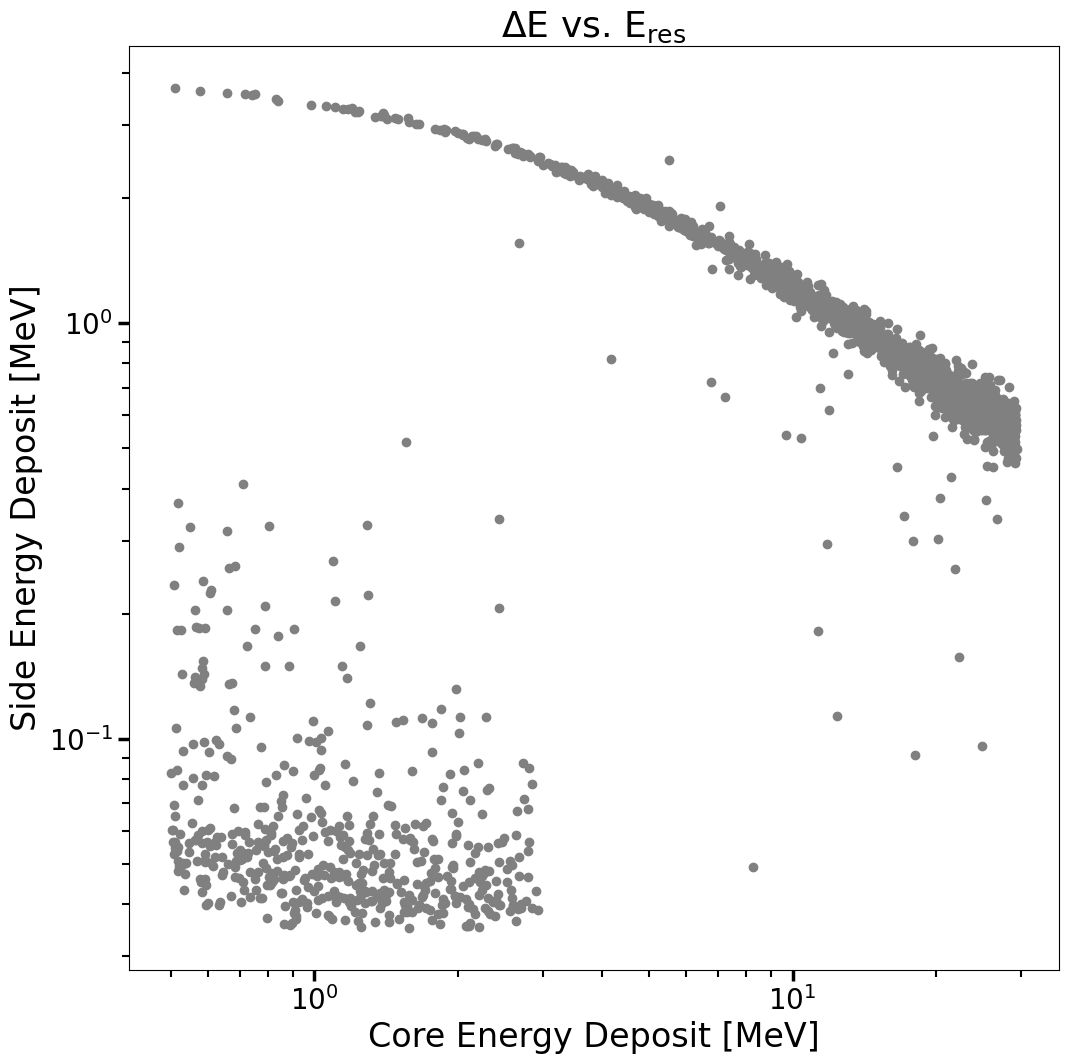

In [6]:
#
# Plotting the ΔE vs. Eres coincidence map.
# ΔE: Energy loss in the Side detector (Y-axis).
# Eres: Residual energy deposited in the Core detector (X-axis).
#

XAXIS = "Edep_Scintillator_MeV"
YAXIS = "Edep_Si_side0_MeV"

TITLE = r"$\Delta$E vs. E$_{\rm res}$"
XAXIS_LABEL = "Core Energy Deposit [MeV]"
YAXIS_LABEL = "Side Energy Deposit [MeV]"

fig, ax = plt.subplots(figsize=(12,12))

# Set logarithmic scale for both axes
ax.set_xscale("log")
ax.set_yscale("log")

# Plot coincidence hits (scatter plots) for protons and electrons (in grey)
ax.scatter(df_p_coinc[XAXIS],df_p_coinc[YAXIS], color="grey") # Protons
ax.scatter(df_e_coinc[XAXIS],df_e_coinc[YAXIS], color="grey") # Electrons

# Labeling and formatting the axes and title
ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)
ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

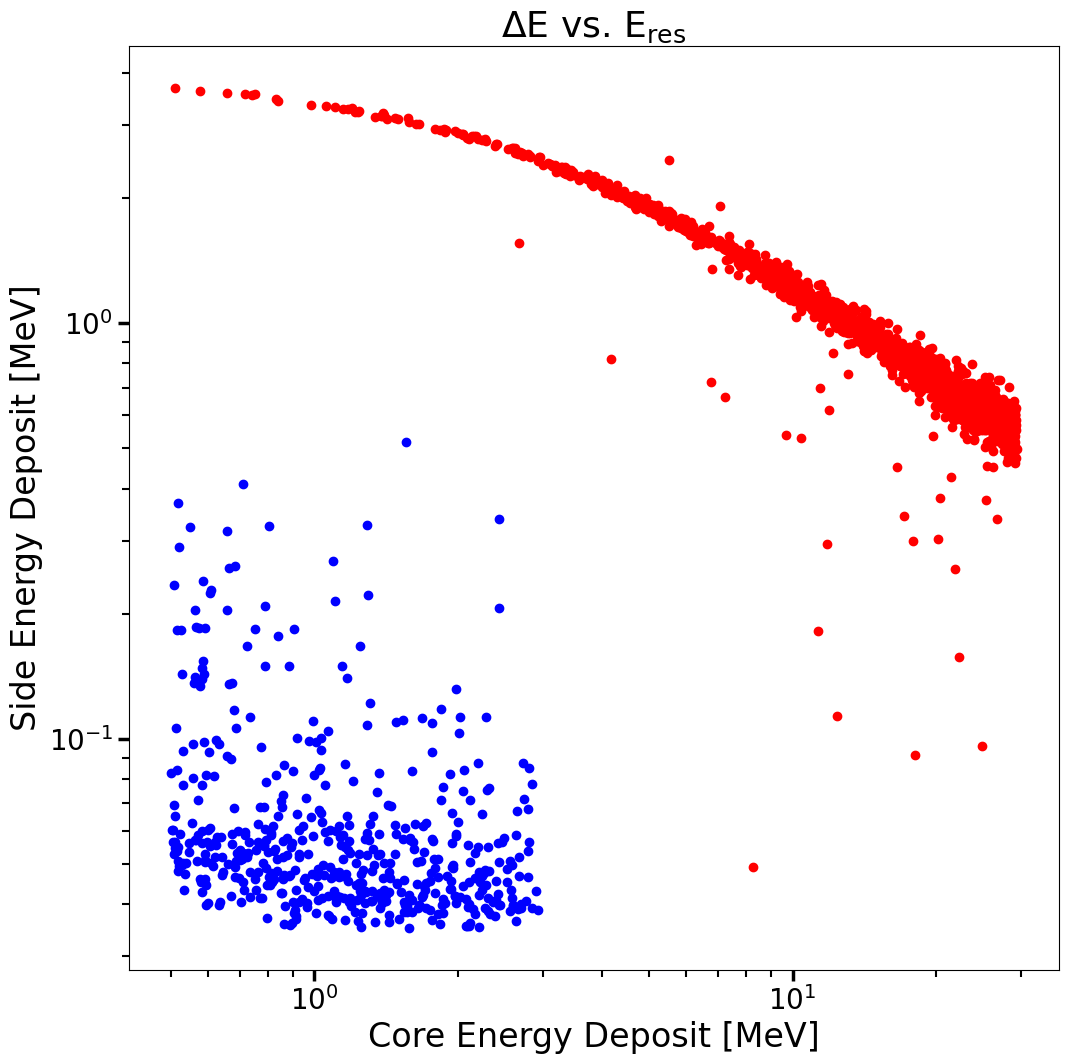

In [7]:
#
# In this cell, we enhance the ΔE vs. Eres plot by adding color coding for particle types.
# Detected electrons are shown in blue, and detected protons are shown in red.
#

XAXIS = "Edep_Scintillator_MeV"
YAXIS = "Edep_Si_side0_MeV"

TITLE = r"$\Delta$E vs. E$_{\rm res}$"
XAXIS_LABEL = "Core Energy Deposit [MeV]"
YAXIS_LABEL = "Side Energy Deposit [MeV]"

fig, ax = plt.subplots(figsize=(12,12))

# Set logarithmic scale for both axes
ax.set_xscale("log")
ax.set_yscale("log")

# Plot coincidence hits (scatter plots) for protons (in red) and electrons (in blue)
ax.scatter(df_p_coinc[XAXIS],df_p_coinc[YAXIS], color="red") # Protons
ax.scatter(df_e_coinc[XAXIS],df_e_coinc[YAXIS], color="blue") # Electrons

# Labeling and formatting the axes and title
ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)
ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

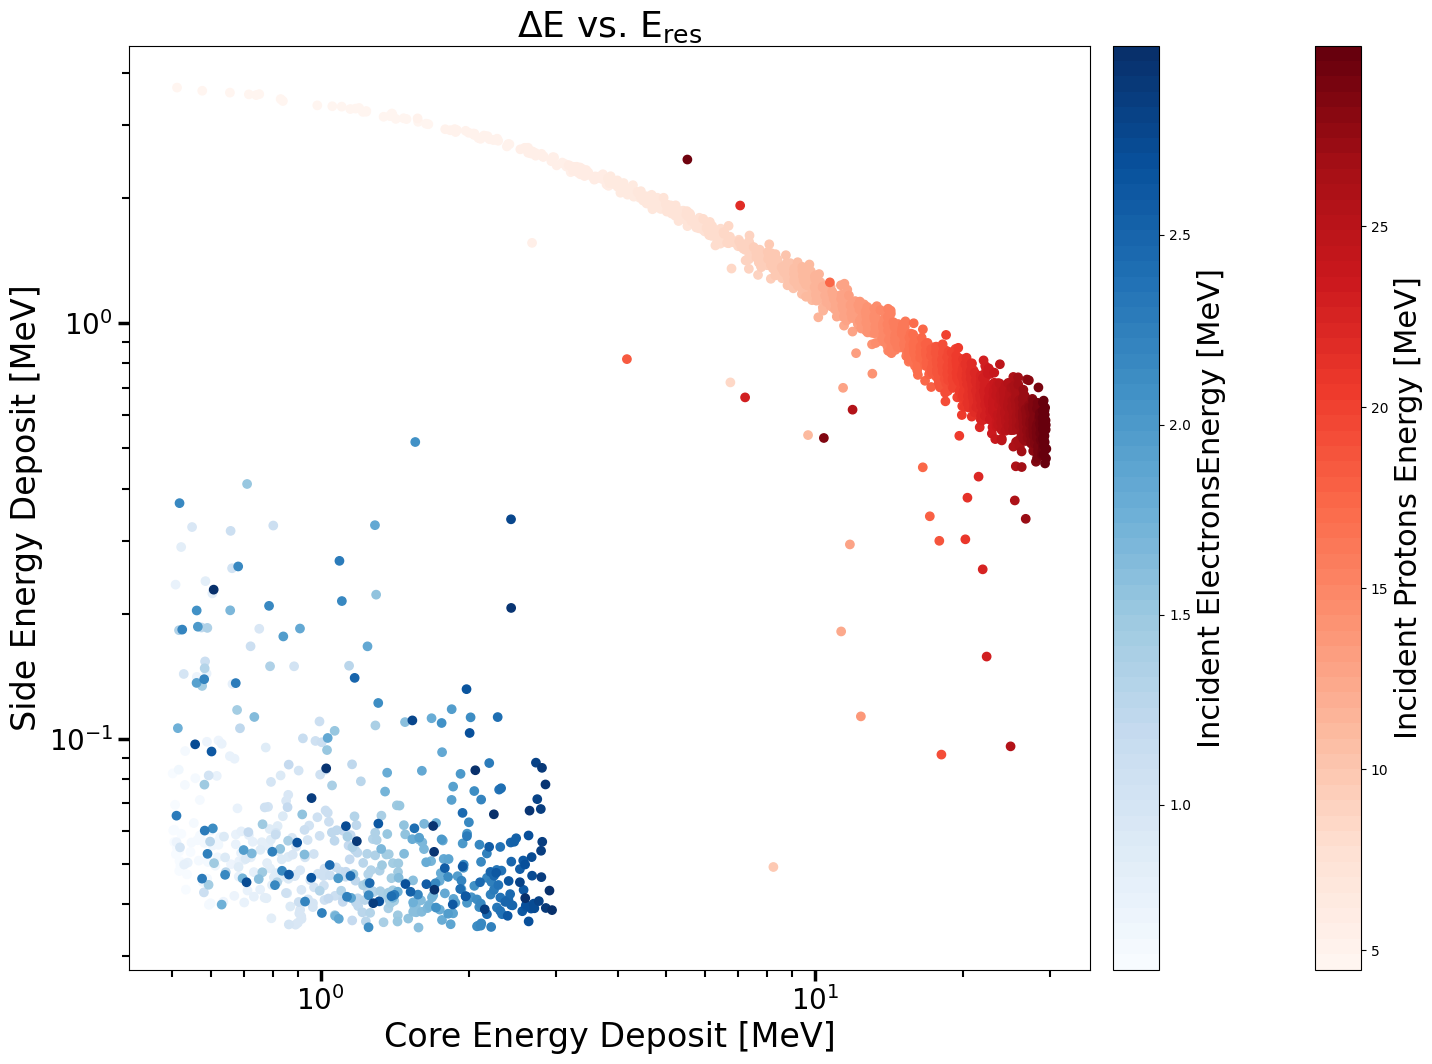

In [8]:
#
# In this cell, we enhance the previous plot by adding a color map based on the incident energy of the particles.
# Detected electrons are shown in blue, and detected protons in red.
# The color intensity represents the incident energy:
# - Lighter shades correspond to lower energies,
# - Darker shades indicate higher energies.
#

XAXIS = "Edep_Scintillator_MeV"
YAXIS = "Edep_Si_side0_MeV"

TITLE = r"$\Delta$E vs. E$_{\rm res}$"
XAXIS_LABEL = "Core Energy Deposit [MeV]"
YAXIS_LABEL = "Side Energy Deposit [MeV]"

# Define color maps for protons and electrons based on incident energ
E_CMAP = plt.get_cmap("Blues", 60)
P_CMAP = plt.get_cmap("Reds", 60)

fig, ax = plt.subplots(figsize=(18,12))

# Set logarithmic scale for both axes
ax.set_xscale("log")
ax.set_yscale("log")

# Plot protons with color map based on incident energy
scat_p = ax.scatter(df_p_coinc[XAXIS],df_p_coinc[YAXIS], c=df_p_coinc["Egun_MeV"], cmap=P_CMAP)
# Plot electrons with color map based on incident energy
scat_e = ax.scatter(df_e_coinc[XAXIS],df_e_coinc[YAXIS], c=df_e_coinc["Egun_MeV"], cmap=E_CMAP)

# Add color bars for protons and electrons
cbar_p = plt.colorbar(scat_p, ax=ax, orientation='vertical', pad=0.02)
cbar_p.set_label('Incident Protons Energy [MeV]', fontsize=FONTSIZE-2)
cbar_e = plt.colorbar(scat_e, ax=ax, orientation='vertical', pad=0.02)
cbar_e.set_label('Incident ElectronsEnergy [MeV]', fontsize=FONTSIZE-2)


# Labeling and formatting the axes and title
ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)
ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

## 2. Anti-coincidence analysis
This section analyzes events where a hit is registered by the Side detector, but no corresponding hit is recorded in the Core detector.

In [9]:
#
# Selection of anti-coincidence hits, i.e., hits registered only by the Side detector.
# Particles that deposited at least 0.035 MeV in the Side detector and
# less than 0.5 MeV in the Core detector.
#

# Apply anti-coincidence selection criteria
df_p_ac = dfs[1].loc[(dfs[1]["Edep_Scintillator_MeV"]<CORE_THRESHOLD)&(dfs[1]["Edep_Si_side0_MeV"] > SIDE_THRESHOLD)]
df_e_ac = dfs[0].loc[(dfs[0]["Edep_Scintillator_MeV"]<CORE_THRESHOLD)&(dfs[0]["Edep_Si_side0_MeV"] > SIDE_THRESHOLD)]

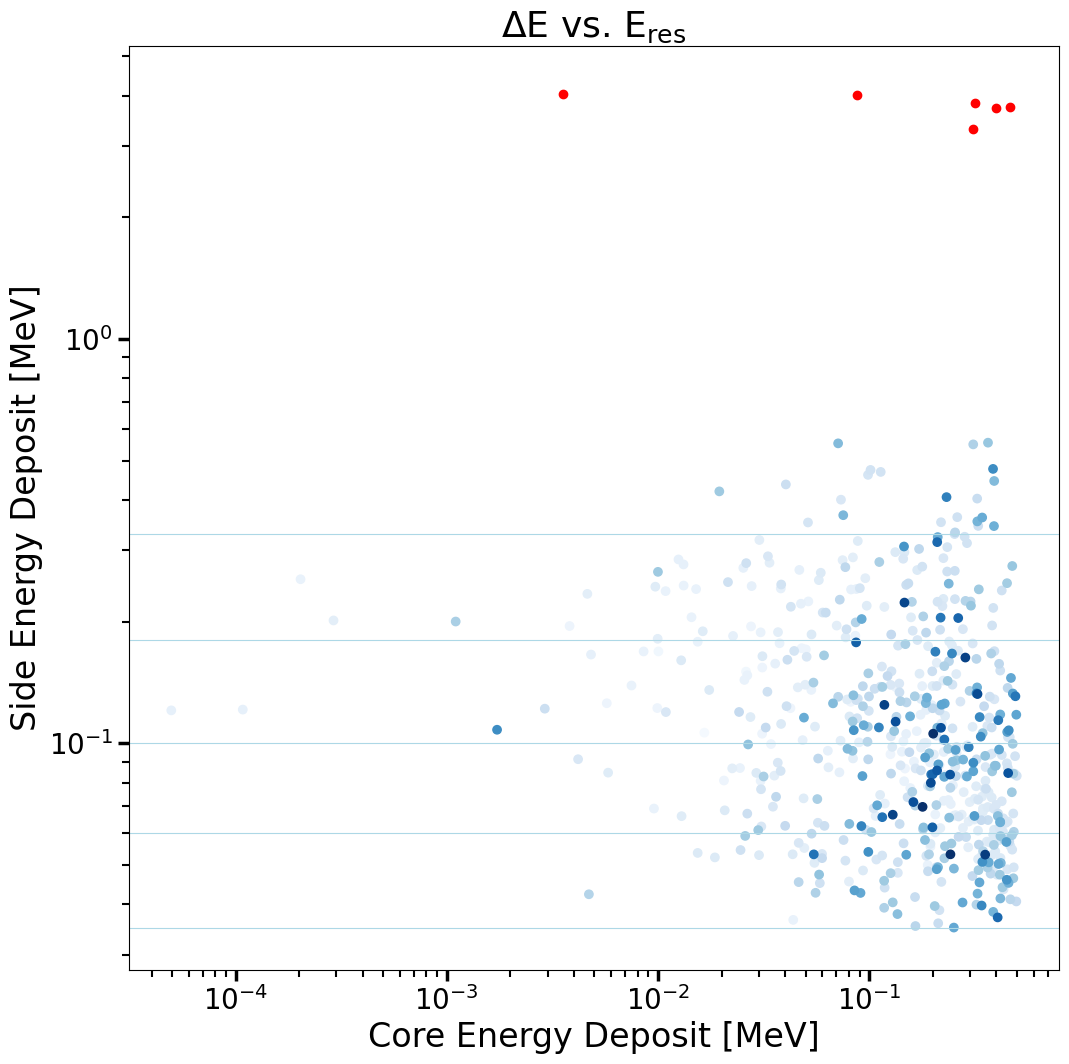

In [10]:
#
# Plotting ΔE vs. Eres for hits registered by the Side detector that reach the Core detector 
# but are not detected by it (i.e., anti-coincidence hits).
# ΔE: The energy loss in the Side detector
# E: The residual energy deposited in Core detector
# 

XAXIS = "Edep_Scintillator_MeV"
YAXIS = "Edep_Si_side0_MeV"

TITLE = r"$\Delta$E vs. E$_{\rm res}$"
XAXIS_LABEL = "Core Energy Deposit [MeV]"
YAXIS_LABEL = "Side Energy Deposit [MeV]"

fig, ax = plt.subplots(figsize=(12,12))

# Set logarithmic scales for both axes
ax.set_xscale("log")
ax.set_yscale("log")

# Plot protons (red color)
ax.scatter(df_p_ac[XAXIS],df_p_ac[YAXIS], color="red")
# Plot electrons (color coded by incident energy, using the blue color map)
ax.scatter(df_e_ac[XAXIS],df_e_ac[YAXIS], c=df_e_ac["Egun_MeV"], cmap=E_CMAP)

# Draw horizontal lines at the energy boundaries for electron channel
for boundary in e_channel_boundaries:
    ax.axhline(y=boundary, lw=0.8, c="lightblue")

# Labeling and formatting the axes and title
ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)
ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

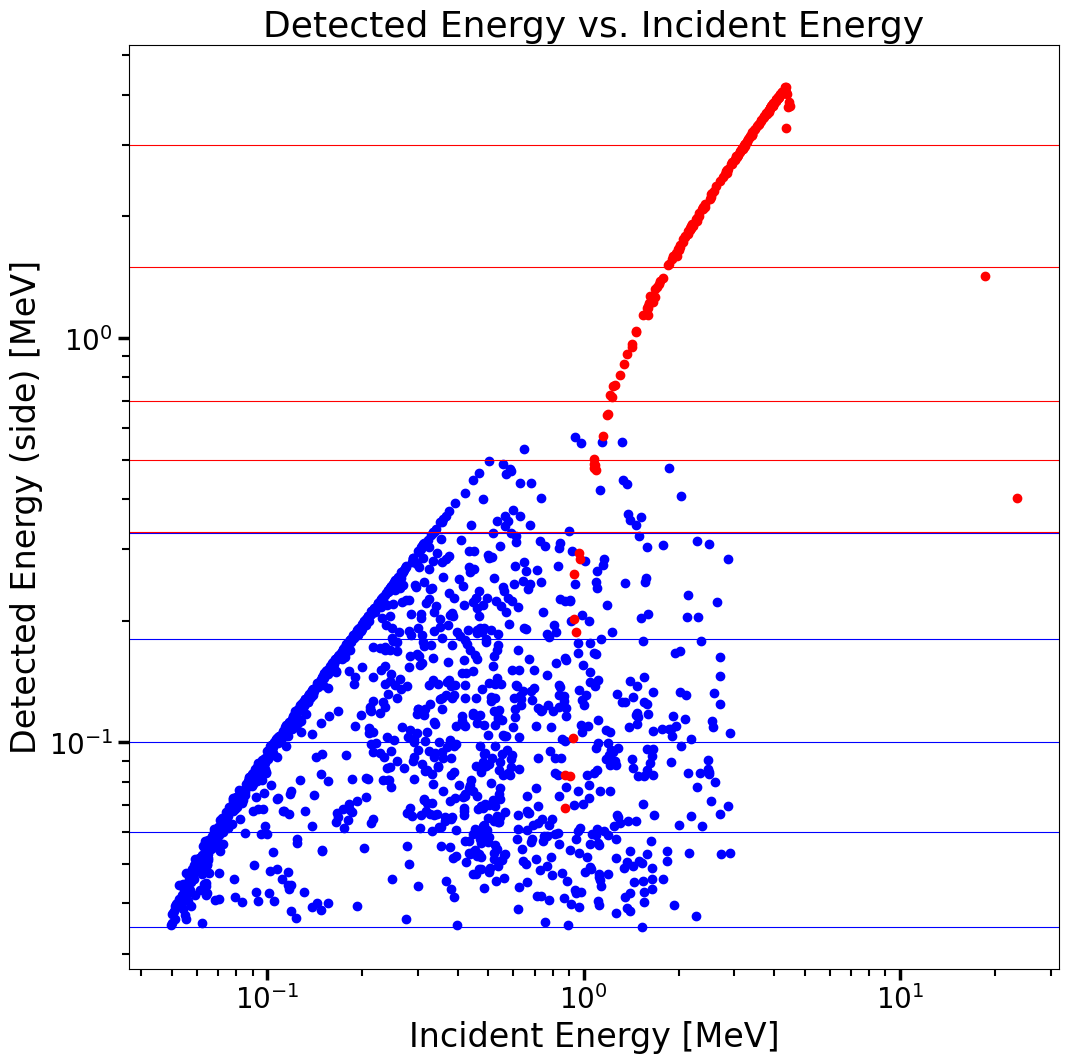

In [11]:
#
# Plot the detected energy by the Side detector as a function of the incident energy.
# - X-axis: Incident energy (Egun) in MeV
# - Y-axis: Detected energy by the Side detector (Edep_Si_side0) in MeV
#

XAXIS = "Egun_MeV"
YAXIS = "Edep_Si_side0_MeV"

TITLE = r"Detected Energy vs. Incident Energy"
XAXIS_LABEL = "Incident Energy [MeV]"
YAXIS_LABEL = "Detected Energy (side) [MeV]"

fig, ax = plt.subplots(figsize=(12,12))

# Set logarithmic scales for both axes
ax.set_xscale("log")
ax.set_yscale("log")

# Plot protons in red
ax.scatter(df_p_ac[XAXIS],df_p_ac[YAXIS], color="red", zorder=3)
# Plot electrons in blue
ax.scatter(df_e_ac[XAXIS],df_e_ac[YAXIS], color="blue")

# Add horizontal lines at the energy boundaries for the electron channel
for boundary in e_channel_boundaries:
    ax.axhline(y=boundary, lw=0.8, c="blue")
    
# Add horizontal lines at the energy boundaries for the proton channel
for boundary in p_channel_boundaries:
    ax.axhline(y=boundary, lw=0.8, c="red")

# Labeling and formatting the axes and title
ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)
ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

## 3. Instrument response 
This section analyzes energy-dependent detection, specifically focusing on the lowest energy electron channel (E1). 
The analysis relies solely on the measurements from the Side detector, examining how electron response varies with incident energy.

In [12]:
# 
# Select electrons whose detected energy in the Side detector falls within the E1 channel range.
# The E1 channel is defined by the energy interval: 0.035 MeV < E < 0.06 MeV
#
e1_selection = df_e_ac.loc[(df_e_ac["Edep_Si_side0_MeV"]>e_channel_boundaries[0])&(df_e_ac["Edep_Si_side0_MeV"]<e_channel_boundaries[1])]

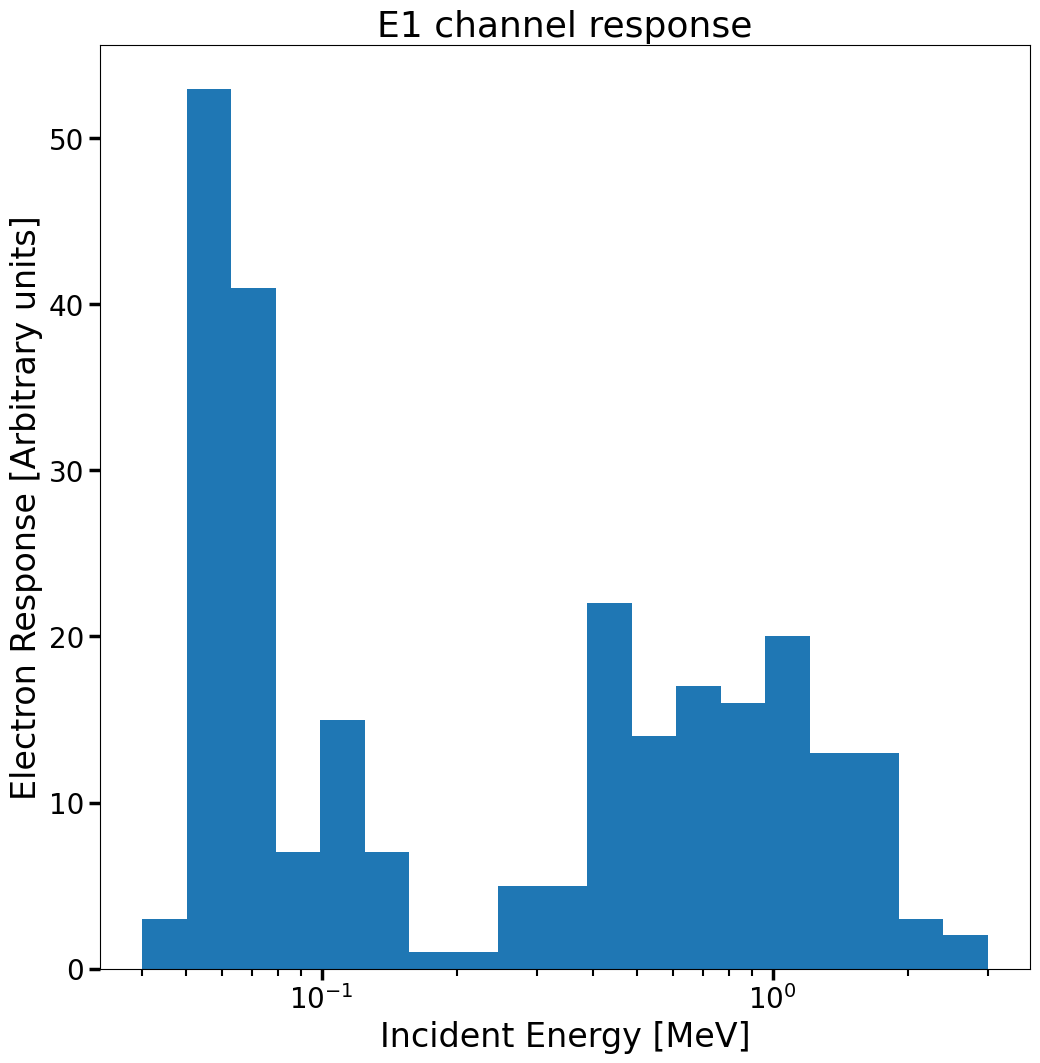

In [13]:
#
# This cell plots a histogram showing the response of the E1 channel.
# It displays the number of electron hits (or responses) in the E1 energy range
# as a function of their incident energy.
#

XAXIS_LABEL = "Incident Energy [MeV]"
YAXIS_LABEL = "Electron Response [Arbitrary units]"
TITLE = "E1 channel response"

fig, ax = plt.subplots(figsize=(12,12))

# Set logarithmic scale for x-axis
ax.set_xscale("log")

# Histogram of incident energies for electrons detected in the E1 channel
ax.hist(e1_selection["Egun_MeV"], bins=np.logspace(np.log10(0.04),np.log10(3),20))

# Labeling and formatting the axes and title
ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)
ax.set_title(TITLE, fontsize=FONTSIZE+2)

plt.show()

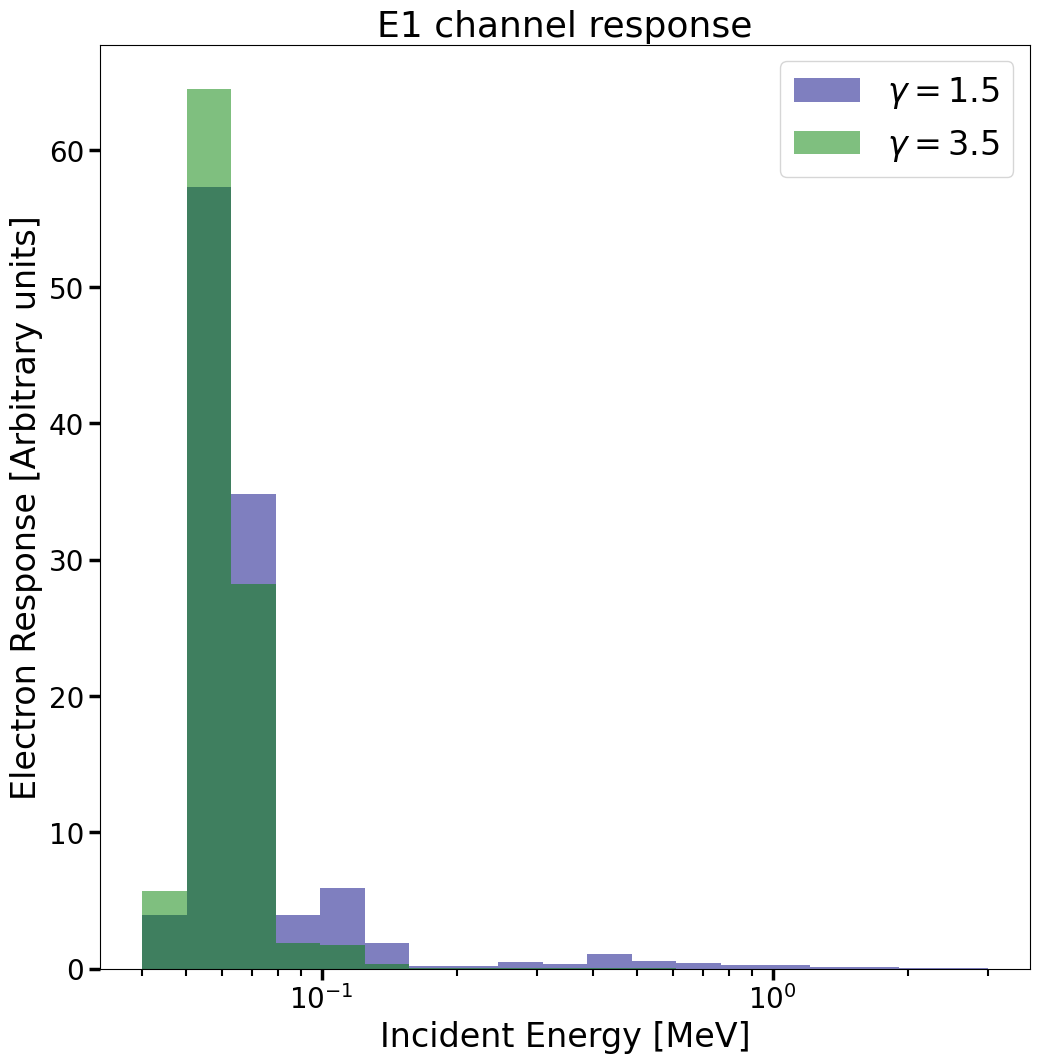

In [14]:
#
# Normalizing the channel response based on different spectral shapes:
# This cell normalizes the E1 channel response for two spectral models:
# 1. A hard spectrum with a power-law index of gamma = 1.5
# 2. A much softer spectrum with a power-law index of gamma = 3.5
#

XAXIS_LABEL = "Incident Energy [MeV]"
YAXIS_LABEL = "Electron Response [Arbitrary units]"
TITLE = "E1 channel response"

fig, ax = plt.subplots(figsize=(12,12))

ax.set_xscale("log")

# Histogram for a hard spectrum (gamma = 1.5)
ax.hist(e1_selection["Egun_MeV"], bins=np.logspace(np.log10(0.04),np.log10(3),20), weights=np.power(e1_selection["Egun_MeV"]/0.06,-1.5), alpha=0.5, color="navy", label=r"$\gamma=1.5$")
# Histogram for a soft spectrum (gamma = 3.5)
ax.hist(e1_selection["Egun_MeV"], bins=np.logspace(np.log10(0.04),np.log10(3),20), weights=np.power(e1_selection["Egun_MeV"]/0.06,-3.5), alpha=0.5, color="green", label=r"$\gamma=3.5$")

# Labeling and formatting the plot
ax.set_ylabel(YAXIS_LABEL, fontsize=FONTSIZE)
ax.set_xlabel(XAXIS_LABEL, fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5)
ax.tick_params(axis='both', which='minor', labelsize=17, length=5, width=1.5)
ax.set_title(TITLE, fontsize=FONTSIZE+2)
ax.legend(fontsize=FONTSIZE)

plt.show()